# Toss ML CTR ÏòàÏ∏° Î™®Îç∏ÎßÅ ÌååÏù¥ÌîÑÎùºÏù∏

## Í∞úÏöî
- **Î™©Ìëú**: Í¥ëÍ≥† ÌÅ¥Î¶≠Î•†(CTR) ÏòàÏ∏°ÏùÑ ÏúÑÌïú Ïù¥ÏßÑ Î∂ÑÎ•ò Î™®Îç∏ Í∞úÎ∞ú
- **Îç∞Ïù¥ÌÑ∞**: 10.7M ÌõàÎ†® ÏÉòÌîå, 119Í∞ú ÌîºÏ≤ò
- **Ï†ëÍ∑ºÎ≤ï**: Îî•Îü¨Îãù Í∏∞Î∞ò CTR ÏòàÏ∏° Î™®Îç∏

In [2]:
# ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, log_loss, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import gc
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import os
import warnings
warnings.filterwarnings('ignore')

# CPU Î∞è Î©ÄÌã∞ÌîÑÎ°úÏÑ∏Ïã± ÏÑ§Ï†ï
CPU_COUNT = 8  # ÏÇ¨Ïö© Í∞ÄÎä•Ìïú CPU ÏΩîÏñ¥ Ïàò
OPTIMAL_WORKERS = min(CPU_COUNT - 1, 6)  # DataLoaderÏö© (1Í∞úÎäî Î©îÏù∏ ÌîÑÎ°úÏÑ∏Ïä§Ïö©)
PROCESSING_WORKERS = CPU_COUNT  # Ï†ÑÏ≤òÎ¶¨Ïö©

# PyTorch Î©ÄÌã∞Ïä§Î†àÎî© ÏÑ§Ï†ï
torch.set_num_threads(CPU_COUNT)
os.environ['OMP_NUM_THREADS'] = str(CPU_COUNT)
os.environ['MKL_NUM_THREADS'] = str(CPU_COUNT)

print(f"CPU ÏΩîÏñ¥ Ïàò: {CPU_COUNT}")
print(f"DataLoader workers: {OPTIMAL_WORKERS}")
print(f"Processing workers: {PROCESSING_WORKERS}")

# ÏãúÎìú Í≥†Ï†ï
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# ÏÑ§Ï†ï
plt.style.use('default')
sns.set_palette("husl")

# Î©îÎ™®Î¶¨ ÏµúÏ†ÅÌôî ÏÑ§Ï†ï
MEMORY_LIMIT_GB = 100 
SAFETY_MARGIN = 0.95   
MAX_MEMORY_GB = MEMORY_LIMIT_GB * SAFETY_MARGIN

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Memory limit: {MAX_MEMORY_GB:.1f}GB")

CPU ÏΩîÏñ¥ Ïàò: 8
DataLoader workers: 6
Processing workers: 8
PyTorch version: 2.3.0+cu121
CUDA available: True
Using device: cuda
Memory limit: 95.0GB


## 1. Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è ÌÉêÏÉâÏ†Å Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù

In [3]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎî©
print("Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...")
train_df = pd.read_parquet("../data/raw/train.parquet", engine="pyarrow")
test_df = pd.read_parquet("../data/raw/test.parquet", engine="pyarrow").drop(columns=['ID'])
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

Îç∞Ïù¥ÌÑ∞ Î°úÎî© Ï§ë...
Train shape: (10704179, 119)
Test shape: (1527298, 118)
Sample submission shape: (1527298, 2)


In [4]:
# Í∏∞Î≥∏ Ï†ïÎ≥¥ ÌôïÏù∏
print("=== ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Í∏∞Î≥∏ Ï†ïÎ≥¥ ===")
print(train_df.info())
print("\n=== ÌÉÄÍ≤ü Î∂ÑÌè¨ ===")
print(train_df['clicked'].value_counts(normalize=True))

print("\n=== Í≤∞Ï∏°Í∞í ÌôïÏù∏ ===")
missing_info = train_df.isnull().sum()
print(f"Í≤∞Ï∏°Í∞íÏù¥ ÏûàÎäî Ïª¨Îüº Ïàò: {(missing_info > 0).sum()}")
if (missing_info > 0).any():
    print(missing_info[missing_info > 0].head(10))

=== ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Í∏∞Î≥∏ Ï†ïÎ≥¥ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10704179 entries, 0 to 10704178
Columns: 119 entries, gender to clicked
dtypes: float32(112), int32(1), object(6)
memory usage: 5.0+ GB
None

=== ÌÉÄÍ≤ü Î∂ÑÌè¨ ===
clicked
0    0.980925
1    0.019075
Name: proportion, dtype: float64

=== Í≤∞Ï∏°Í∞í ÌôïÏù∏ ===
Í≤∞Ï∏°Í∞íÏù¥ ÏûàÎäî Ïª¨Îüº Ïàò: 96
gender       17208
age_group    17208
l_feat_2     17208
l_feat_8     17208
l_feat_18    17208
l_feat_19    17208
l_feat_20    17208
l_feat_21    17208
l_feat_22    17208
l_feat_23    17208
dtype: int64


In [5]:
# ÌîºÏ≤ò Í∑∏Î£πÎ≥Ñ Î∂ÑÏÑù
feature_groups = {
    'demographic': ['gender', 'age_group'],
    'contextual': ['inventory_id', 'day_of_week', 'hour', 'seq'],
    'l_feat': [col for col in train_df.columns if col.startswith('l_feat_')],
    'feat_e': [col for col in train_df.columns if col.startswith('feat_e_')],
    'feat_d': [col for col in train_df.columns if col.startswith('feat_d_')],
    'feat_c': [col for col in train_df.columns if col.startswith('feat_c_')],
    'feat_b': [col for col in train_df.columns if col.startswith('feat_b_')],
    'feat_a': [col for col in train_df.columns if col.startswith('feat_a_')],
    'history_a': [col for col in train_df.columns if col.startswith('history_a_')]
}

print("=== ÌîºÏ≤ò Í∑∏Î£πÎ≥Ñ Í∞úÏàò ===")
for group, features in feature_groups.items():
    print(f"{group}: {len(features)}Í∞ú")

=== ÌîºÏ≤ò Í∑∏Î£πÎ≥Ñ Í∞úÏàò ===
demographic: 2Í∞ú
contextual: 4Í∞ú
l_feat: 27Í∞ú
feat_e: 10Í∞ú
feat_d: 6Í∞ú
feat_c: 8Í∞ú
feat_b: 6Í∞ú
feat_a: 18Í∞ú
history_a: 7Í∞ú


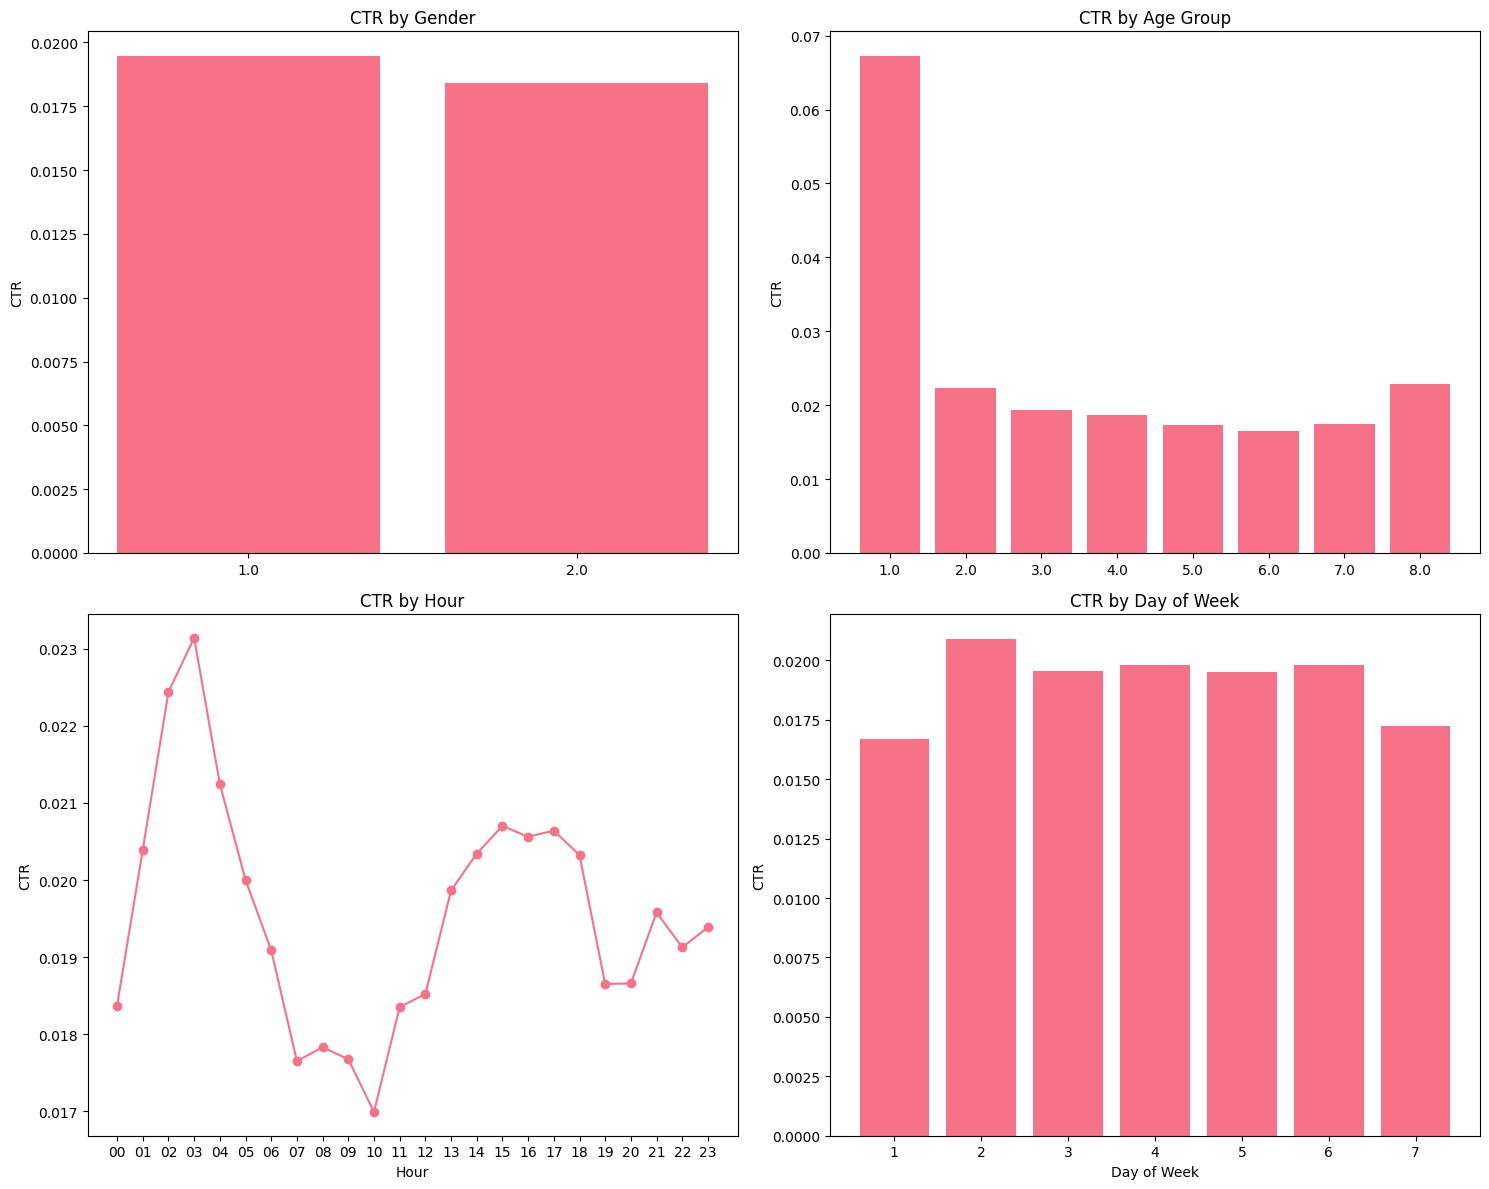

In [6]:
# ÌÉÄÍ≤üÍ≥º Ï£ºÏöî ÌîºÏ≤òÎì§ Í∞ÑÏùò Í¥ÄÍ≥Ñ ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ÏÑ±Î≥ÑÎ≥Ñ ÌÅ¥Î¶≠Î•†
gender_ctr = train_df.groupby('gender')['clicked'].agg(['count', 'mean'])
axes[0,0].bar(gender_ctr.index, gender_ctr['mean'])
axes[0,0].set_title('CTR by Gender')
axes[0,0].set_ylabel('CTR')

# Ïó∞Î†πÎåÄÎ≥Ñ ÌÅ¥Î¶≠Î•†
age_ctr = train_df.groupby('age_group')['clicked'].agg(['count', 'mean'])
axes[0,1].bar(age_ctr.index, age_ctr['mean'])
axes[0,1].set_title('CTR by Age Group')
axes[0,1].set_ylabel('CTR')

# ÏãúÍ∞ÑÎåÄÎ≥Ñ ÌÅ¥Î¶≠Î•†
hour_ctr = train_df.groupby('hour')['clicked'].agg(['count', 'mean'])
axes[1,0].plot(hour_ctr.index, hour_ctr['mean'], marker='o')
axes[1,0].set_title('CTR by Hour')
axes[1,0].set_xlabel('Hour')
axes[1,0].set_ylabel('CTR')

# ÏöîÏùºÎ≥Ñ ÌÅ¥Î¶≠Î•†
dow_ctr = train_df.groupby('day_of_week')['clicked'].agg(['count', 'mean'])
axes[1,1].bar(dow_ctr.index, dow_ctr['mean'])
axes[1,1].set_title('CTR by Day of Week')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('CTR')

plt.tight_layout()
plt.show()

## 2. ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ Î∞è Ï†ÑÏ≤òÎ¶¨

In [7]:
# Ï†ÑÏó≠ Ìï®ÏàòÎì§ (pickle Î¨∏Ï†ú Ìï¥Í≤∞ÏùÑ ÏúÑÌï¥)
def process_categorical_column_global(args):
    """Î≤îÏ£ºÌòï Ïª¨Îüº Ï≤òÎ¶¨ Ìï®Ïàò (Ï†ÑÏó≠ Ìï®Ïàò)"""
    col, values = args
    from sklearn.preprocessing import LabelEncoder
    
    # unique values ÌôïÏù∏
    unique_values = values.value_counts().index.tolist()
    
    if len(unique_values) > 300:
        return col, None, None
    
    # 'missing' ÌÅ¥ÎûòÏä§Í∞Ä ÏóÜÏúºÎ©¥ Ï∂îÍ∞Ä
    if 'missing' not in unique_values:
        unique_values.append('missing')
    
    le = LabelEncoder()
    le.fit(unique_values)
    encoded_values = le.transform(values)
    
    return col, encoded_values, le

def process_numerical_column_global(args):
    """ÏàòÏπòÌòï Ïª¨Îüº Ï≤òÎ¶¨ Ìï®Ïàò (Ï†ÑÏó≠ Ìï®Ïàò)"""
    col, data = args
    from sklearn.preprocessing import StandardScaler
    
    if data is not None:
        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(data.fillna(0).values.reshape(-1, 1))
        return col, scaled_values.flatten(), scaler
    return col, None, None

class FeatureProcessor:
    def __init__(self):
        self.label_encoders = {}
        self.scalers = {}
        self.categorical_features = []
        self.numerical_features = []
        self.high_cardinality_features = []
        
    def identify_feature_types(self, df):
        """ÌîºÏ≤ò ÌÉÄÏûÖ ÏãùÎ≥Ñ - Î©ÄÌã∞ÌîÑÎ°úÏÑ∏Ïã± ÌôúÏö©"""
        categorical_features = []
        numerical_features = []
        high_cardinality_features = []
        
        print("Analyzing feature types with CPU optimization...")
        
        # Ïª¨ÎüºÎì§ÏùÑ Ï≤≠ÌÅ¨Î°ú ÎÇòÎà†ÏÑú Î≥ëÎ†¨ Ï≤òÎ¶¨
        columns = [col for col in df.columns if col not in ['clicked', 'ID']]
        
        def analyze_column(col):
            # Îçî ÏûëÏùÄ ÏÉòÌîåÎ°ú Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Ï§ÑÏûÑ
            sample_size = min(50000, len(df))
            sample_df = df[col].sample(n=sample_size, random_state=42)
            nunique_sample = sample_df.nunique()
            
            # Ï†ÑÏ≤¥ unique Ï∂îÏ†ï
            nunique_est = int(nunique_sample * (len(df) / sample_size))
            
            col_type = 'numerical'
            if df[col].dtype == 'object':
                if nunique_est > 300:
                    col_type = 'high_cardinality'
                else:
                    col_type = 'categorical'
            elif nunique_sample < 30:
                col_type = 'categorical'
            
            return col, col_type, nunique_est
        
        # ThreadPoolExecutor ÏÇ¨Ïö© (ProcessPoolExecutor ÎåÄÏã†)
        with ThreadPoolExecutor(max_workers=PROCESSING_WORKERS) as executor:
            results = list(executor.map(analyze_column, columns))
        
        for col, col_type, nunique_est in results:
            if col_type == 'high_cardinality':
                high_cardinality_features.append(col)
                print(f"High cardinality feature excluded: {col} (estimated unique: {nunique_est})")
            elif col_type == 'categorical':
                categorical_features.append(col)
            else:
                numerical_features.append(col)
                
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.high_cardinality_features = high_cardinality_features
        
        print(f"Categorical features: {len(categorical_features)}")
        print(f"Numerical features: {len(numerical_features)}")
        print(f"High cardinality features excluded: {len(high_cardinality_features)}")
        
        # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
        gc.collect()
        
    def fit_transform_categorical(self, df):
        """Î≤îÏ£ºÌòï ÌîºÏ≤ò Ïù∏ÏΩîÎî© - ThreadPool ÏÇ¨Ïö©"""
        print("Processing categorical features with CPU optimization...")
        df_encoded = df.copy()
        
        # high cardinality features Ï†úÍ±∞
        for col in self.high_cardinality_features:
            if col in df_encoded.columns:
                df_encoded = df_encoded.drop(columns=[col])
                print(f"Dropped high cardinality feature: {col}")
        
        # ThreadPoolExecutorÎ°ú Î≤îÏ£ºÌòï ÌîºÏ≤ò Ï≤òÎ¶¨ (Îçî ÏïàÏ†ïÏ†Å)
        categorical_args = []
        for col in self.categorical_features:
            if col in df.columns:
                values = df[col].astype(str).fillna('missing')
                categorical_args.append((col, values))
        
        print(f"Processing {len(categorical_args)} categorical features in parallel...")
        
        # ThreadPoolExecutor ÏÇ¨Ïö© (pickle Î¨∏Ï†ú ÏóÜÏùå)
        with ThreadPoolExecutor(max_workers=min(PROCESSING_WORKERS, len(categorical_args))) as executor:
            results = list(executor.map(process_categorical_column_global, categorical_args))
        
        # Í≤∞Í≥º Ï†ÅÏö©
        for col, encoded_values, le in results:
            if encoded_values is not None:
                df_encoded[col] = encoded_values
                self.label_encoders[col] = le
                print(f"Processed {col}")
            else:
                print(f"Skipped {col}: too many unique values")
                if col in df_encoded.columns:
                    df_encoded = df_encoded.drop(columns=[col])
                
        return df_encoded
    
    def transform_categorical(self, df):
        """Î≤îÏ£ºÌòï ÌîºÏ≤ò Ïù∏ÏΩîÎî© (transform only)"""
        df_encoded = df.copy()
        
        # high cardinality features Ï†úÍ±∞
        for col in self.high_cardinality_features:
            if col in df_encoded.columns:
                df_encoded = df_encoded.drop(columns=[col])
        
        for col in self.categorical_features:
            if col in df.columns and col in self.label_encoders:
                # ÏÉàÎ°úÏö¥ Í∞íÎì§ÏùÑ Ï≤òÎ¶¨
                values = df[col].astype(str).fillna('missing')
                known_classes = set(self.label_encoders[col].classes_)
                values = values.apply(lambda x: x if x in known_classes else 'missing')
                df_encoded[col] = self.label_encoders[col].transform(values)
                
        return df_encoded
    
    def fit_transform_numerical(self, df):
        """ÏàòÏπòÌòï ÌîºÏ≤ò Ïä§ÏºÄÏùºÎßÅ - ThreadPool ÏÇ¨Ïö©"""
        print("Processing numerical features with CPU optimization...")
        df_scaled = df.copy()
        
        # ThreadPoolExecutorÎ°ú ÏàòÏπòÌòï ÌîºÏ≤ò Ï≤òÎ¶¨
        numerical_args = []
        for col in self.numerical_features:
            if col in df.columns:
                numerical_args.append((col, df[col]))
        
        print(f"Processing {len(numerical_args)} numerical features in parallel...")
        
        with ThreadPoolExecutor(max_workers=PROCESSING_WORKERS) as executor:
            results = list(executor.map(process_numerical_column_global, numerical_args))
        
        # Í≤∞Í≥º Ï†ÅÏö©
        for col, scaled_values, scaler in results:
            if scaled_values is not None:
                df_scaled[col] = scaled_values
                self.scalers[col] = scaler
                
        return df_scaled
    
    def transform_numerical(self, df):
        """ÏàòÏπòÌòï ÌîºÏ≤ò Ïä§ÏºÄÏùºÎßÅ (transform only)"""
        df_scaled = df.copy()
        
        for col in self.numerical_features:
            if col in df.columns and col in self.scalers:
                df_scaled[col] = self.scalers[col].transform(df[[col]].fillna(0))
                
        return df_scaled

# Îç∞Ïù¥ÌÑ∞ ÏÉòÌîåÎßÅÏúºÎ°ú Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Ï°∞Ï†à
print("Î©îÎ™®Î¶¨ ÏÇ¨Ïö©ÎüâÏùÑ ÏµúÏ†ÅÌôîÌïú Ï†ÑÏ≤òÎ¶¨ ÏãúÏûë...")
print(f"ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {train_df.shape}")

# Î©îÎ™®Î¶¨Í∞Ä Ï∂©Î∂ÑÌïòÏßÄ ÏïäÏùÑ Í≤ΩÏö∞ Îç∞Ïù¥ÌÑ∞ ÏÉòÌîåÎßÅ
data_memory_estimate = train_df.memory_usage(deep=True).sum() / 1e9  # GB Îã®ÏúÑ
print(f"ÏòàÏÉÅ Îç∞Ïù¥ÌÑ∞ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: {data_memory_estimate:.2f}GB")

if data_memory_estimate > MAX_MEMORY_GB * 0.6:  # 60% Ïù¥ÏÉÅÏù¥Î©¥ ÏÉòÌîåÎßÅ
    sample_ratio = (MAX_MEMORY_GB * 0.6) / data_memory_estimate
    sample_size = int(len(train_df) * sample_ratio)
    print(f"Î©îÎ™®Î¶¨ Ï†úÌïúÏúºÎ°ú Îç∞Ïù¥ÌÑ∞ ÏÉòÌîåÎßÅ: {sample_size:,} ÏÉòÌîå ({sample_ratio:.2%})")
    
    # Ï∏µÌôî ÏÉòÌîåÎßÅÏúºÎ°ú ÌÉÄÍ≤ü ÎπÑÏú® Ïú†ÏßÄ
    train_sampled = train_df.groupby('clicked', group_keys=False).apply(
        lambda x: x.sample(int(len(x) * sample_ratio), random_state=SEED)
    ).reset_index(drop=True)
else:
    train_sampled = train_df
    
print(f"ÏµúÏ¢Ö ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {train_sampled.shape}")

processor = FeatureProcessor()
processor.identify_feature_types(train_sampled)

print("\nÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ÏãúÏûë...")
train_processed = processor.fit_transform_categorical(train_sampled)
print("Î≤îÏ£ºÌòï ÌîºÏ≤ò Ïù∏ÏΩîÎî© ÏôÑÎ£å")

train_processed = processor.fit_transform_numerical(train_processed)
print("ÏàòÏπòÌòï ÌîºÏ≤ò Ïä§ÏºÄÏùºÎßÅ ÏôÑÎ£å")

print("\nÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ÏãúÏûë...")
test_processed = processor.transform_categorical(test_df)
test_processed = processor.transform_numerical(test_processed)

print("\nÏ†ÑÏ≤òÎ¶¨ ÏôÑÎ£å!")
print(f"Train processed shape: {train_processed.shape}")
print(f"Test processed shape: {test_processed.shape}")

# ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÏÇ≠Ï†úÎ°ú Î©îÎ™®Î¶¨ ÌôïÎ≥¥
del train_df, test_df
if 'train_sampled' in locals():
    del train_sampled
gc.collect()

# Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ ÌôïÏù∏
print(f"ÌòÑÏû¨ Ï≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: {train_processed.memory_usage(deep=True).sum() / 1e9:.2f}GB")

Î©îÎ™®Î¶¨ ÏÇ¨Ïö©ÎüâÏùÑ ÏµúÏ†ÅÌôîÌïú Ï†ÑÏ≤òÎ¶¨ ÏãúÏûë...
ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: (10704179, 119)
ÏòàÏÉÅ Îç∞Ïù¥ÌÑ∞ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: 29.77GB
ÏµúÏ¢Ö ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: (10704179, 119)
Analyzing feature types with CPU optimization...
High cardinality feature excluded: gender (estimated unique: 428)
High cardinality feature excluded: age_group (estimated unique: 1712)
High cardinality feature excluded: inventory_id (estimated unique: 3853)
High cardinality feature excluded: day_of_week (estimated unique: 1498)
High cardinality feature excluded: hour (estimated unique: 5138)
High cardinality feature excluded: seq (estimated unique: 10586004)
Categorical features: 33
Numerical features: 79
High cardinality features excluded: 6

ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ÏãúÏûë...
Processing categorical features with CPU optimization...
Dropped high cardinality feature: gender
Dropped high cardinality feature: age_group
Dropped high cardinality feature: inventory_id
Dropped high cardinality feature:

## 3. Îî•Îü¨Îãù Î™®Îç∏ Ï†ïÏùò

In [11]:
class CTRDataset(Dataset):
    def __init__(self, features, targets=None):
        self.features = torch.FloatTensor(features.values)
        self.targets = torch.FloatTensor(targets.values) if targets is not None else None
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.targets is not None:
            return self.features[idx], self.targets[idx]
        return self.features[idx]

class DeepCTRModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout_rate=0.3):
        super(DeepCTRModel, self).__init__()
        
        # Input layer with batch normalization
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        # Deep layers (ÌÅ¨Í∏∞Î•º Ï§ÑÏó¨ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Í∞êÏÜå: 512‚Üí256, 256‚Üí128, 128‚Üí64)
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
            
        self.deep_layers = nn.Sequential(*layers)
        
        # Output layer (sigmoid Ï†úÍ±∞)
        self.output = nn.Linear(prev_dim, 1)
        
    def forward(self, x):
        x = self.input_bn(x)
        x = self.deep_layers(x)
        x = self.output(x)
        return x.squeeze()

# Î™®Îç∏ ÏÑ§Ï†ï
feature_cols = [col for col in train_processed.columns if col not in ['clicked']]
input_dim = len(feature_cols)

print(f"Input dimension: {input_dim}")
print(f"Feature columns: {len(feature_cols)}")

# Î©îÎ™®Î¶¨ Ï∂îÏ†ï Í≥ÑÏÇ∞
def estimate_model_memory(input_dim, hidden_dims, batch_size):
    """Î™®Îç∏ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Ï∂îÏ†ï"""
    param_count = input_dim * hidden_dims[0]
    for i in range(len(hidden_dims)-1):
        param_count += hidden_dims[i] * hidden_dims[i+1]
    param_count += hidden_dims[-1]  # output layer
    
    # ÌååÎùºÎØ∏ÌÑ∞ Î©îÎ™®Î¶¨ (float32 = 4 bytes)
    param_memory = param_count * 4 / 1e9  # GB
    
    # Î∞∞Ïπò Î©îÎ™®Î¶¨ (forward + backward)
    batch_memory = batch_size * input_dim * 4 * 3 / 1e9  # GB (3x for forward, backward, optimizer)
    
    return param_memory, batch_memory, param_count

hidden_dims = [256, 128, 64]  # Ï§ÑÏñ¥Îì† Î™®Îç∏ ÌÅ¨Í∏∞
param_mem, batch_mem_4k, param_count = estimate_model_memory(input_dim, hidden_dims, 4096)
param_mem, batch_mem_1k, _ = estimate_model_memory(input_dim, hidden_dims, 1024)

print(f"\n=== Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Ï∂îÏ†ï ===")
print(f"Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞: {param_count:,}Í∞ú")
print(f"ÌååÎùºÎØ∏ÌÑ∞ Î©îÎ™®Î¶¨: {param_mem:.2f}GB")
print(f"Î∞∞Ïπò Î©îÎ™®Î¶¨ (batch_size=4096): {batch_mem_4k:.2f}GB")
print(f"Î∞∞Ïπò Î©îÎ™®Î¶¨ (batch_size=1024): {batch_mem_1k:.2f}GB")
print(f"Ï¥ù Î©îÎ™®Î¶¨ ÏòàÏÉÅ (batch_size=1024): {param_mem + batch_mem_1k:.2f}GB")

Input dimension: 112
Feature columns: 112

=== Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Ï∂îÏ†ï ===
Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞: 69,696Í∞ú
ÌååÎùºÎØ∏ÌÑ∞ Î©îÎ™®Î¶¨: 0.00GB
Î∞∞Ïπò Î©îÎ™®Î¶¨ (batch_size=4096): 0.01GB
Î∞∞Ïπò Î©îÎ™®Î¶¨ (batch_size=1024): 0.00GB
Ï¥ù Î©îÎ™®Î¶¨ ÏòàÏÉÅ (batch_size=1024): 0.00GB


## 4. Î™®Îç∏ ÌõàÎ†® Î∞è Í≤ÄÏ¶ù

In [12]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.BCEWithLogitsLoss()  # BCELoss ÎåÄÏã† BCEWithLogitsLoss ÏÇ¨Ïö©
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    
    # Mixed PrecisionÏùÑ ÏúÑÌïú GradScaler
    scaler = GradScaler()
    
    train_losses = []
    val_losses = []
    val_aucs = []
    
    best_val_auc = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        
        for i, (batch_features, batch_targets) in enumerate(train_loader):
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            
            optimizer.zero_grad()
            
            # Mixed Precision Training
            with autocast():
                outputs = model(batch_features)
                loss = criterion(outputs, batch_targets)
            
            # Backward pass with scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            
            # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨ (Îß§ 100 Î∞∞ÏπòÎßàÎã§)
            if i % 100 == 0:
                torch.cuda.empty_cache()
                gc.collect()
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch_features, batch_targets in val_loader:
                batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
                
                # Mixed Precision Inference
                with autocast():
                    outputs = model(batch_features)
                    loss = criterion(outputs, batch_targets)
                
                val_loss += loss.item()
                # ÏãúÍ∑∏Î™®Ïù¥ÎìúÎ•º ÏàòÎèôÏúºÎ°ú Ï†ÅÏö©ÌïòÏó¨ ÌôïÎ•†Í∞í ÏÉùÏÑ±
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_targets.extend(batch_targets.cpu().numpy())
        
        # Î©îÌä∏Î¶≠ Í≥ÑÏÇ∞
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_auc = roc_auc_score(val_targets, val_preds)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        
        # Best model Ï†ÄÏû•
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict().copy()
        
        scheduler.step(val_loss)
        
        # ÏóêÌè¨ÌÅ¨ÎßàÎã§ Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
        torch.cuda.empty_cache()
        gc.collect()
        
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')
    
    # Best model Î°úÎìú
    model.load_state_dict(best_model_state)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_aucs': val_aucs,
        'best_val_auc': best_val_auc
    }

In [13]:
# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
X = train_processed[feature_cols]
y = train_processed['clicked']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Train CTR: {y_train.mean():.4f}")
print(f"Validation CTR: {y_val.mean():.4f}")

# CPUÏôÄ Î©îÎ™®Î¶¨ Í∏∞Î∞ò Î∞∞Ïπò ÏÇ¨Ïù¥Ï¶à ÏµúÏ†ÅÌôî
data_size_gb = train_processed.memory_usage(deep=True).sum() / 1e9
sample_count = len(X_train)

# CPU ÏΩîÏñ¥ ÏàòÎ•º Í≥†Î†§Ìïú Î∞∞Ïπò ÏÇ¨Ïù¥Ï¶à Í≥ÑÏÇ∞
base_batch_size = 1024
cpu_multiplier = CPU_COUNT / 4  # 4ÏΩîÏñ¥ Í∏∞Ï§ÄÏúºÎ°ú Ïä§ÏºÄÏùºÎßÅ
memory_factor = min(2.0, MAX_MEMORY_GB / 20)  # 20GB Í∏∞Ï§Ä

optimal_batch_size = int(base_batch_size * cpu_multiplier * memory_factor)

# Î∞∞Ïπò ÏÇ¨Ïù¥Ï¶à Î≤îÏúÑ Ï†úÌïú
if data_size_gb > 15:
    optimal_batch_size = min(optimal_batch_size, 512)
elif data_size_gb > 10:
    optimal_batch_size = min(optimal_batch_size, 1024)
elif data_size_gb < 5:
    optimal_batch_size = min(optimal_batch_size, 4096)
else:
    optimal_batch_size = min(optimal_batch_size, 2048)

# ÏµúÏÜå/ÏµúÎåÄ Ï†úÌïú
optimal_batch_size = max(256, min(optimal_batch_size, 4096))

print(f"Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {data_size_gb:.2f}GB")
print(f"ÏÉòÌîå Ïàò: {sample_count:,}")
print(f"CPU Í∏∞Î∞ò ÏµúÏ†Å Î∞∞Ïπò ÏÇ¨Ïù¥Ï¶à: {optimal_batch_size}")
print(f"ÏòàÏÉÅ Î∞∞Ïπò Ïàò: {sample_count // optimal_batch_size}")

# CPU Ìö®Ïú®ÏÑ±ÏùÑ ÏúÑÌïú DataLoader ÏÑ§Ï†ï
effective_workers = min(OPTIMAL_WORKERS, 6)  # DataLoader worker Ïàò Ï†úÌïú
prefetch_factor = 2  # CPUÍ∞Ä ÎßéÏùÑ Îïå ÎØ∏Î¶¨ Î°úÎî©Ìï† Î∞∞Ïπò Ïàò

print(f"DataLoader workers: {effective_workers}")
print(f"Prefetch factor: {prefetch_factor}")

# Îç∞Ïù¥ÌÑ∞Î°úÎçî ÏÉùÏÑ± (CPU ÏµúÏ†ÅÌôî ÏÑ§Ï†ï)
train_dataset = CTRDataset(X_train, y_train)
val_dataset = CTRDataset(X_val, y_val)

train_loader = DataLoader(
    train_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=True, 
    num_workers=effective_workers,
    pin_memory=torch.cuda.is_available(),  # GPU ÏÇ¨Ïö© ÏãúÎßå ÌôúÏÑ±Ìôî
    persistent_workers=True if effective_workers > 0 else False,
    prefetch_factor=prefetch_factor if effective_workers > 0 else 2,
    drop_last=True  # ÎßàÏßÄÎßâ Î∞∞Ïπò ÌÅ¨Í∏∞ ÏùºÏ†ïÌïòÍ≤å Ïú†ÏßÄ
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=False, 
    num_workers=effective_workers,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=True if effective_workers > 0 else False,
    prefetch_factor=prefetch_factor if effective_workers > 0 else 2,
    drop_last=False
)

# Î™®Îç∏ Ï¥àÍ∏∞Ìôî
model = DeepCTRModel(input_dim=input_dim, hidden_dims=[256, 128, 64], dropout_rate=0.3).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# CPU Î∞è Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ Ï∂îÏ†ï
cpu_efficiency = (optimal_batch_size * effective_workers) / (CPU_COUNT * 1000)
total_estimated_memory = (
    train_processed.memory_usage(deep=True).sum() / 1e9 +  # Îç∞Ïù¥ÌÑ∞
    sum(p.numel() for p in model.parameters()) * 4 / 1e9 +  # Î™®Îç∏
    optimal_batch_size * input_dim * 4 * 3 / 1e9 +  # Î∞∞Ïπò Ï≤òÎ¶¨
    effective_workers * optimal_batch_size * input_dim * 4 / 1e9  # Worker Î≤ÑÌçº
)

print(f"\n=== Î¶¨ÏÜåÏä§ ÏÇ¨Ïö©Îüâ ÏòàÏ∏° ===")
print(f"Ï¥ù ÏòàÏÉÅ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: {total_estimated_memory:.2f}GB")
print(f"CPU Ìö®Ïú®ÏÑ± ÏßÄÌëú: {cpu_efficiency:.3f}")
print(f"Î∞∞ÏπòÎãπ Ï≤òÎ¶¨ ÏÉòÌîå: {optimal_batch_size * effective_workers}")

if total_estimated_memory > MAX_MEMORY_GB:
    print(f"‚ö†Ô∏è  ÏòàÏÉÅ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©ÎüâÏù¥ Ï†úÌïú({MAX_MEMORY_GB:.1f}GB)ÏùÑ Ï¥àÍ≥ºÌï† Ïàò ÏûàÏäµÎãàÎã§.")
    print("Î∞∞Ïπò ÏÇ¨Ïù¥Ï¶àÎÇò ÏõåÏª§ ÏàòÎ•º Ï§ÑÏù¥Îäî Í≤ÉÏùÑ Í∂åÏû•Ìï©ÎãàÎã§.")
else:
    print(f"‚úÖ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©ÎüâÏù¥ Ï†úÌïú ÎÇ¥Ïóê ÏûàÏäµÎãàÎã§.")

print("\nÌõàÎ†® ÏãúÏûë...")

# Î©îÎ™®Î¶¨ Ï†ïÎ¶¨ ÌõÑ ÌõàÎ†® ÏãúÏûë
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

history = train_model(model, train_loader, val_loader, epochs=15, lr=0.001)

Train samples: 8563343
Validation samples: 2140836
Train CTR: 0.0191
Validation CTR: 0.0191
Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: 6.25GB
ÏÉòÌîå Ïàò: 8,563,343
CPU Í∏∞Î∞ò ÏµúÏ†Å Î∞∞Ïπò ÏÇ¨Ïù¥Ï¶à: 2048
ÏòàÏÉÅ Î∞∞Ïπò Ïàò: 4181
DataLoader workers: 6
Prefetch factor: 2
Model parameters: 71,265

=== Î¶¨ÏÜåÏä§ ÏÇ¨Ïö©Îüâ ÏòàÏ∏° ===
Ï¥ù ÏòàÏÉÅ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ: 6.26GB
CPU Ìö®Ïú®ÏÑ± ÏßÄÌëú: 1.536
Î∞∞ÏπòÎãπ Ï≤òÎ¶¨ ÏÉòÌîå: 12288
‚úÖ Î©îÎ™®Î¶¨ ÏÇ¨Ïö©ÎüâÏù¥ Ï†úÌïú ÎÇ¥Ïóê ÏûàÏäµÎãàÎã§.

ÌõàÎ†® ÏãúÏûë...
Epoch 1/15 - Train Loss: 0.0975, Val Loss: 0.0893, Val AUC: 0.6878
Epoch 2/15 - Train Loss: 0.0909, Val Loss: 0.0892, Val AUC: 0.6900
Epoch 3/15 - Train Loss: 0.0901, Val Loss: 0.0891, Val AUC: 0.6927
Epoch 4/15 - Train Loss: 0.0898, Val Loss: 0.0892, Val AUC: 0.6936
Epoch 5/15 - Train Loss: 0.0896, Val Loss: 0.0891, Val AUC: 0.6948
Epoch 6/15 - Train Loss: 0.0895, Val Loss: 0.0890, Val AUC: 0.6960
Epoch 7/15 - Train Loss: 0.0895, Val Loss: 0.0889, Val AUC: 0.6967
Epoch 8/15 - Train Loss: 0.0895, Val Loss: 0.0889, Val

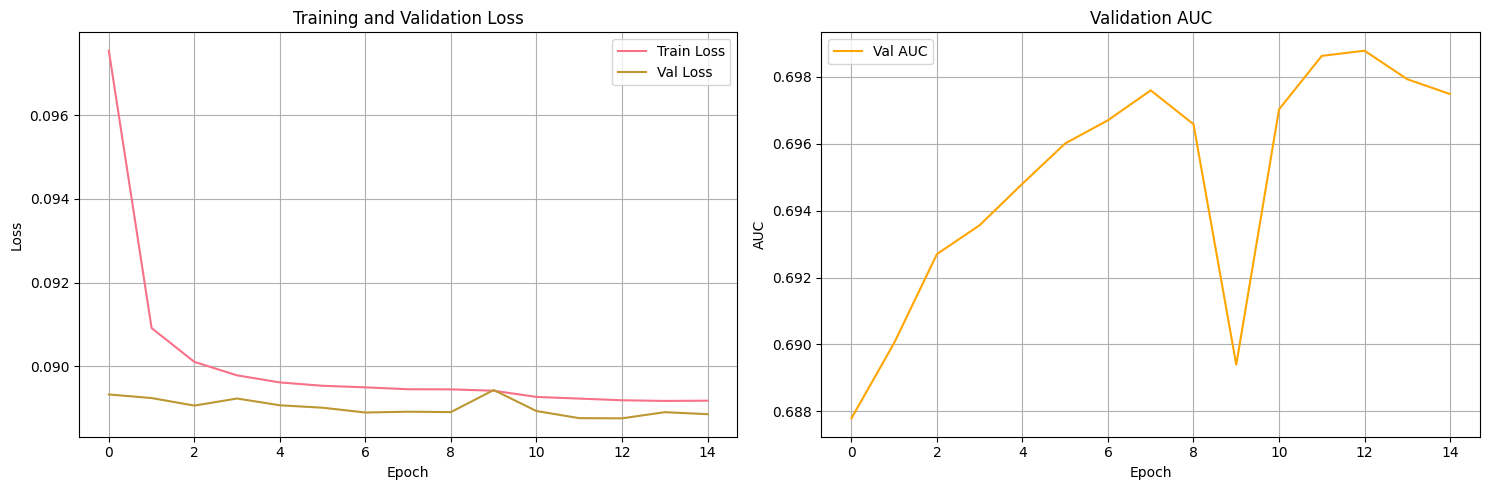


Best Validation AUC: 0.6988


In [14]:
# ÌõàÎ†® Í≤∞Í≥º ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss Í≥°ÏÑ†
axes[0].plot(history['train_losses'], label='Train Loss')
axes[0].plot(history['val_losses'], label='Val Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# AUC Í≥°ÏÑ†
axes[1].plot(history['val_aucs'], label='Val AUC', color='orange')
axes[1].set_title('Validation AUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"\nBest Validation AUC: {history['best_val_auc']:.4f}")

## 5. ÏòàÏ∏° Î∞è Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±

In [15]:
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° (CPU ÏµúÏ†ÅÌôî)
model.eval()
test_features = test_processed[feature_cols]
test_dataset = CTRDataset(test_features)

# CPU ÏµúÏ†ÅÌôîÎêú ÏòàÏ∏°Ïö© DataLoader
test_loader = DataLoader(
    test_dataset, 
    batch_size=optimal_batch_size, 
    shuffle=False, 
    num_workers=effective_workers,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=True if effective_workers > 0 else False,
    prefetch_factor=prefetch_factor if effective_workers > 0 else 2
)

test_predictions = []
total_batches = len(test_loader)

print("CPU ÏµúÏ†ÅÌôîÎêú ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° Ï§ë...")
print(f"Ï¥ù {total_batches} Î∞∞Ïπò, Î∞∞Ïπò ÌÅ¨Í∏∞: {optimal_batch_size}")

with torch.no_grad():
    for i, batch_features in enumerate(test_loader):
        batch_features = batch_features.to(device, non_blocking=True)
        
        # Mixed PrecisionÏúºÎ°ú ÏòàÏ∏°
        with autocast():
            outputs = model(batch_features)
            # ÏãúÍ∑∏Î™®Ïù¥ÎìúÎ•º ÏàòÎèôÏúºÎ°ú Ï†ÅÏö©ÌïòÏó¨ ÌôïÎ•†Í∞í ÏÉùÏÑ±
            predictions = torch.sigmoid(outputs)
        
        test_predictions.extend(predictions.cpu().numpy())
        
        # ÏßÑÌñâÎ•† ÌëúÏãú (CPU Ìö®Ïú®ÏÑ± Í≥†Î†§)
        if i % (total_batches // 10 + 1) == 0:
            progress = (i + 1) / total_batches * 100
            print(f"ÏßÑÌñâÎ•†: {progress:.1f}% ({i+1}/{total_batches})")
        
        # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨ (CPU ÏµúÏ†ÅÌôîÎêú Ï£ºÍ∏∞)
        if i % max(50, total_batches // 20) == 0:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

# ÏµúÏ¢Ö Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

print(f"\nÏòàÏ∏° ÏôÑÎ£å! Ï¥ù {len(test_predictions)}Í∞ú ÏÉòÌîå")
print(f"ÏòàÏ∏°Í∞í Î≤îÏúÑ: [{min(test_predictions):.4f}, {max(test_predictions):.4f}]")
print(f"ÏòàÏ∏°Í∞í ÌèâÍ∑†: {np.mean(test_predictions):.4f}")

# CPU ÏÇ¨Ïö© ÌÜµÍ≥Ñ
print(f"\n=== CPU ÏµúÏ†ÅÌôî Í≤∞Í≥º ===")
print(f"ÏÇ¨Ïö©Îêú Worker: {effective_workers}Í∞ú")
print(f"Î∞∞ÏπòÎãπ ÏÉòÌîå Ïàò: {optimal_batch_size}")
print(f"Ï¥ù Ï≤òÎ¶¨Îüâ: {len(test_predictions)} ÏÉòÌîå")

CPU ÏµúÏ†ÅÌôîÎêú ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° Ï§ë...
Ï¥ù 746 Î∞∞Ïπò, Î∞∞Ïπò ÌÅ¨Í∏∞: 2048
ÏßÑÌñâÎ•†: 0.1% (1/746)
ÏßÑÌñâÎ•†: 10.2% (76/746)
ÏßÑÌñâÎ•†: 20.2% (151/746)
ÏßÑÌñâÎ•†: 30.3% (226/746)
ÏßÑÌñâÎ•†: 40.3% (301/746)
ÏßÑÌñâÎ•†: 50.4% (376/746)
ÏßÑÌñâÎ•†: 60.5% (451/746)
ÏßÑÌñâÎ•†: 70.5% (526/746)
ÏßÑÌñâÎ•†: 80.6% (601/746)
ÏßÑÌñâÎ•†: 90.6% (676/746)

ÏòàÏ∏° ÏôÑÎ£å! Ï¥ù 1527298Í∞ú ÏÉòÌîå
ÏòàÏ∏°Í∞í Î≤îÏúÑ: [0.0002, 0.1248]
ÏòàÏ∏°Í∞í ÌèâÍ∑†: 0.0189

=== CPU ÏµúÏ†ÅÌôî Í≤∞Í≥º ===
ÏÇ¨Ïö©Îêú Worker: 6Í∞ú
Î∞∞ÏπòÎãπ ÏÉòÌîå Ïàò: 2048
Ï¥ù Ï≤òÎ¶¨Îüâ: 1527298 ÏÉòÌîå


Ï†úÏ∂ú ÌååÏùº Ï†ÄÏû• ÏôÑÎ£å: deep_ctr_submission.csv

=== Ï†úÏ∂ú ÌååÏùº Í≤ÄÏ¶ù ===
Ï†úÏ∂ú ÌååÏùº shape: (1527298, 2)
ID Ï§ëÎ≥µ Ïó¨Î∂Ä: False
ÏòàÏ∏°Í∞í Î≤îÏúÑ: [0.0002, 0.1248]
ÏòàÏ∏°Í∞íÏù¥ [0,1] Î≤îÏúÑ ÎÇ¥Ïù∏ÏßÄ: True


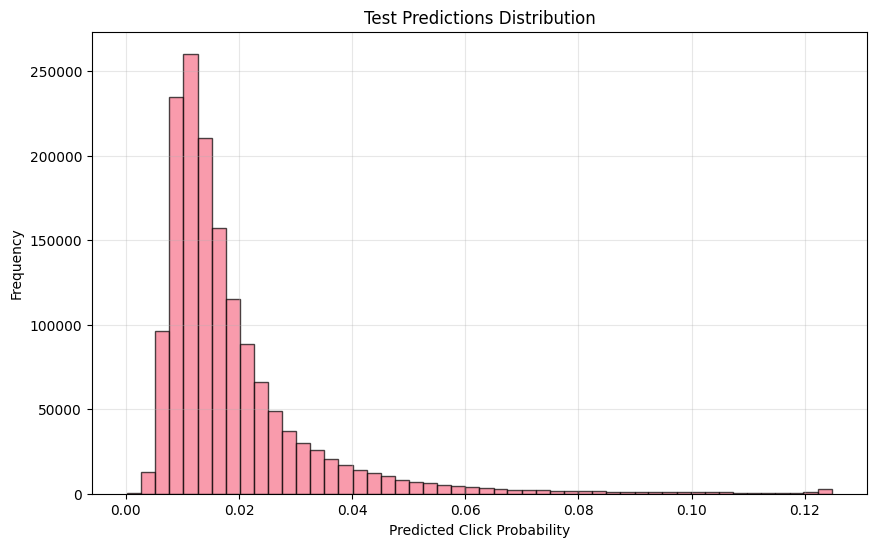

In [16]:
# Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±
submission = sample_submission.copy()
submission['clicked'] = test_predictions

# Ï†úÏ∂ú ÌååÏùº Ï†ÄÏû•
submission.to_csv('../outputs/deep_ctr_submission.csv', index=False)
print("Ï†úÏ∂ú ÌååÏùº Ï†ÄÏû• ÏôÑÎ£å: deep_ctr_submission.csv")

# Ï†úÏ∂ú ÌååÏùº Í≤ÄÏ¶ù
print("\n=== Ï†úÏ∂ú ÌååÏùº Í≤ÄÏ¶ù ===")
print(f"Ï†úÏ∂ú ÌååÏùº shape: {submission.shape}")
print(f"ID Ï§ëÎ≥µ Ïó¨Î∂Ä: {submission['ID'].duplicated().any()}")
print(f"ÏòàÏ∏°Í∞í Î≤îÏúÑ: [{submission['clicked'].min():.4f}, {submission['clicked'].max():.4f}]")
print(f"ÏòàÏ∏°Í∞íÏù¥ [0,1] Î≤îÏúÑ ÎÇ¥Ïù∏ÏßÄ: {(submission['clicked'] >= 0).all() and (submission['clicked'] <= 1).all()}")

# ÏòàÏ∏° Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
plt.hist(submission['clicked'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Test Predictions Distribution')
plt.xlabel('Predicted Click Probability')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Î™®Îç∏ ÏÑ±Îä• Î∂ÑÏÑù Î∞è ÌîºÏ≤ò Ï§ëÏöîÎèÑ

=== ÏµúÏ¢Ö Í≤ÄÏ¶ù ÏÑ±Îä• ===
Validation AUC: 0.6975
Validation LogLoss: 0.0888


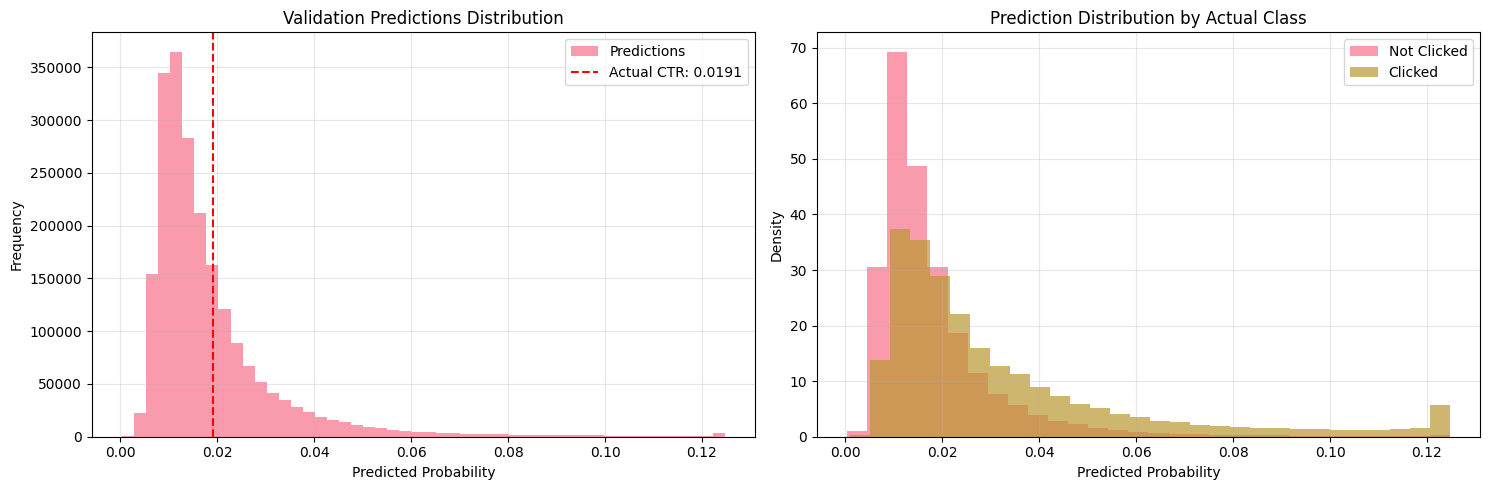

In [17]:
# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÏÉÅÏÑ∏ Î∂ÑÏÑù
model.eval()
with torch.no_grad():
    val_preds = []
    for batch_features, _ in val_loader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features)
        # ÏãúÍ∑∏Î™®Ïù¥ÎìúÎ•º ÏàòÎèôÏúºÎ°ú Ï†ÅÏö©ÌïòÏó¨ ÌôïÎ•†Í∞í ÏÉùÏÑ±
        predictions = torch.sigmoid(outputs)
        val_preds.extend(predictions.cpu().numpy())

val_auc = roc_auc_score(y_val, val_preds)
val_logloss = log_loss(y_val, val_preds)

print("=== ÏµúÏ¢Ö Í≤ÄÏ¶ù ÏÑ±Îä• ===")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Validation LogLoss: {val_logloss:.4f}")

# ÏòàÏ∏°Í∞í Î∂ÑÌè¨ ÎπÑÍµê
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° Î∂ÑÌè¨
axes[0].hist(val_preds, bins=50, alpha=0.7, label='Predictions')
axes[0].axvline(y_val.mean(), color='red', linestyle='--', label=f'Actual CTR: {y_val.mean():.4f}')
axes[0].set_title('Validation Predictions Distribution')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ÌÅ¥Î¶≠/ÎπÑÌÅ¥Î¶≠Î≥Ñ ÏòàÏ∏°Í∞í Î∂ÑÌè¨
clicked_preds = [pred for pred, actual in zip(val_preds, y_val) if actual == 1]
not_clicked_preds = [pred for pred, actual in zip(val_preds, y_val) if actual == 0]

axes[1].hist(not_clicked_preds, bins=30, alpha=0.7, label='Not Clicked', density=True)
axes[1].hist(clicked_preds, bins=30, alpha=0.7, label='Clicked', density=True)
axes[1].set_title('Prediction Distribution by Actual Class')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Î™®Îç∏ ÏöîÏïΩ
print("\n" + "="*50)
print("              Î™®Îç∏ ÌõàÎ†® ÏôÑÎ£å!")
print("="*50)
print(f"üìä Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: {train_processed.shape[0]:,} ÌõàÎ†® ÏÉòÌîå, {test_processed.shape[0]:,} ÌÖåÏä§Ìä∏ ÏÉòÌîå")
print(f"üî¢ ÌîºÏ≤ò Ïàò: {input_dim}Í∞ú")
print(f"üéØ Î≤†Ïä§Ìä∏ Í≤ÄÏ¶ù AUC: {history['best_val_auc']:.4f}")
print(f"üìà ÏµúÏ¢Ö Í≤ÄÏ¶ù AUC: {val_auc:.4f}")
print(f"üìâ Í≤ÄÏ¶ù LogLoss: {val_logloss:.4f}")
print(f"üé≤ Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}Í∞ú")
print(f"üíæ Ï†úÏ∂ú ÌååÏùº: deep_ctr_submission.csv")
print("="*50)


              Î™®Îç∏ ÌõàÎ†® ÏôÑÎ£å!
üìä Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: 10,704,179 ÌõàÎ†® ÏÉòÌîå, 1,527,298 ÌÖåÏä§Ìä∏ ÏÉòÌîå
üî¢ ÌîºÏ≤ò Ïàò: 112Í∞ú
üéØ Î≤†Ïä§Ìä∏ Í≤ÄÏ¶ù AUC: 0.6988
üìà ÏµúÏ¢Ö Í≤ÄÏ¶ù AUC: 0.6975
üìâ Í≤ÄÏ¶ù LogLoss: 0.0888
üé≤ Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞: 71,265Í∞ú
üíæ Ï†úÏ∂ú ÌååÏùº: deep_ctr_submission.csv
